<a href="https://colab.research.google.com/github/Innocente0/linear-regression-model_summative/blob/main/malaria_death_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import joblib
from sklearn.preprocessing import StandardScaler

In [20]:
df = pd.read_csv('malaria_death_prediction.csv')
print (df)

                                Country  Year              No. of cases  \
0                           Afghanistan  2017     630308[495000-801000]   
1                               Algeria  2017                         0   
2                                Angola  2017  4615605[3106000-6661000]   
3                             Argentina  2017                         0   
4                               Armenia  2017                         0   
..                                  ...   ...                       ...   
851  Venezuela (Bolivarian Republic of)  2010        57257[47000-74000]   
852                            Viet Nam  2010        23062[21000-26000]   
853                               Yemen  2010   1134927[611000-2686000]   
854                              Zambia  2010  2169307[1449000-3095000]   
855                            Zimbabwe  2010   1095083[606000-1717000]   

         No. of deaths  No. of cases_median  No. of cases_min  \
0         298[110-510]            

In [21]:
rwanda = df[df['Country'] == 'Rwanda'].copy()
print(rwanda.shape)
print(rwanda[['Year', 'No. of cases_median', 'No. of deaths_median']])

(8, 11)
     Year  No. of cases_median  No. of deaths_median
78   2017              6172220                  3270
185  2016              6608358                  3242
292  2015              3799535                  3218
399  2014              2405272                  3202
506  2013              1304560                  3200
613  2012               748975                  3209
720  2011               401794                  3218
827  2010              1260186                  3253


In [22]:
rwanda[['Year','No. of cases_median','No. of deaths_median']].describe()

,Year,No. of cases_median,No. of deaths_median
count,8.00000,8.000000e+00,8.000000
mean,2013.50000,2.837612e+06,3226.500000
std,2.44949,2.437343e+06,25.601339
min,2010.00000,4.017940e+05,3200.000000
25%,2011.75000,1.132383e+06,3207.250000
50%,2013.50000,1.854916e+06,3218.000000
75%,2015.25000,4.392706e+06,3244.750000
max,2017.00000,6.608358e+06,3270.000000


In [23]:
rwanda.isna().sum()

,0
Country,0
Year,0
No. of cases,0
No. of deaths,0
No. of cases_median,0
No. of cases_min,0
No. of cases_max,0
No. of deaths_median,0
No. of deaths_min,0
No. of deaths_max,0


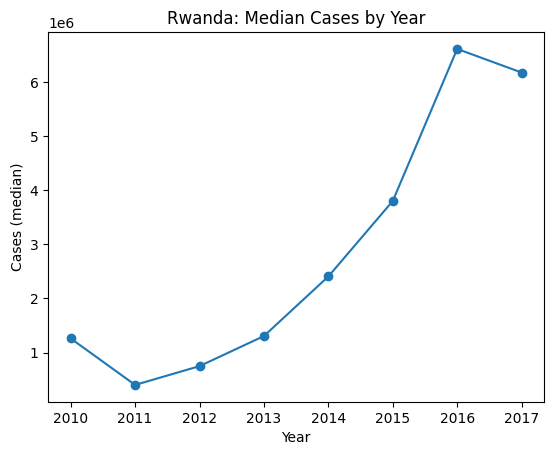

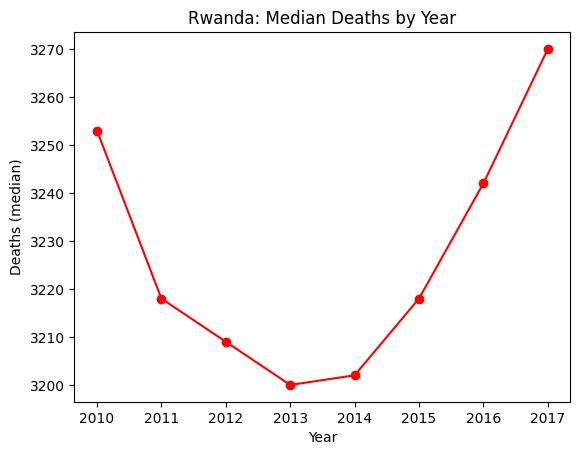

In [24]:
plt.plot(rwanda['Year'], rwanda['No. of cases_median'], marker='o')
plt.title('Rwanda: Median Cases by Year')
plt.xlabel('Year'); plt.ylabel('Cases (median)')
plt.show()

plt.plot(rwanda['Year'], rwanda['No. of deaths_median'], marker='o', color='red')
plt.title('Rwanda: Median Deaths by Year')
plt.xlabel('Year'); plt.ylabel('Deaths (median)')
plt.show()

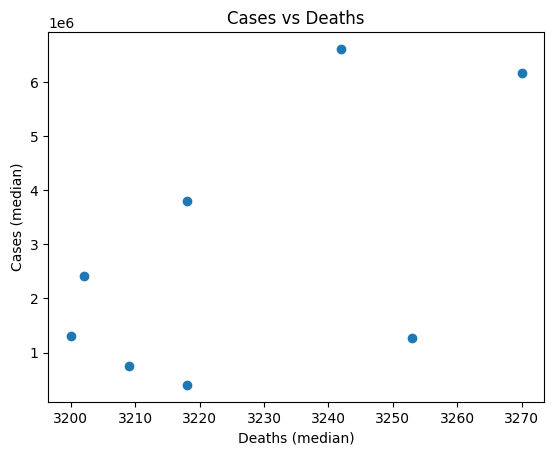

In [25]:
plt.scatter(rwanda['No. of deaths_median'], rwanda['No. of cases_median'])
plt.title('Cases vs Deaths'); plt.xlabel('Deaths (median)'); plt.ylabel('Cases (median)')
plt.show()

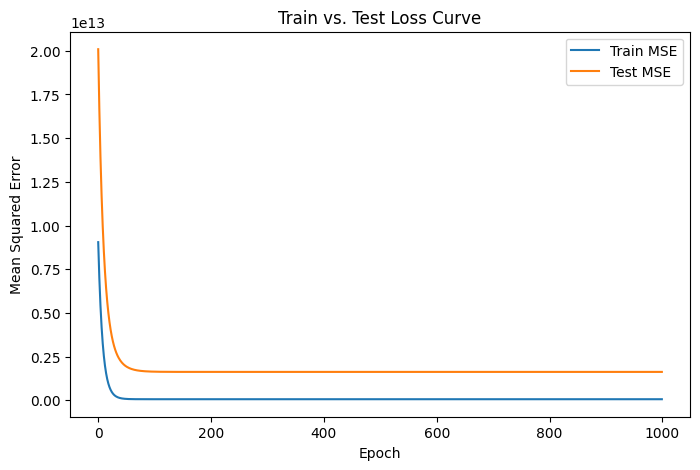

In [26]:
# Preparing X, y and split
X = rwanda[['Year', 'No. of deaths_median']].values
y = rwanda['No. of cases_median'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardizing data
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# Initialize SGDRegressor for incremental learning
model = SGDRegressor(
    loss='squared_error',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    tol=None,
    shuffle=False,
    random_state=0
)

# Partial-fit loop and record losses
train_losses, test_losses = [], []
n_epochs = 1000

for epoch in range(n_epochs):
    model.partial_fit(X_train_s, y_train)
    train_losses.append(mean_squared_error(y_train, model.predict(X_train_s)))
    test_losses.append( mean_squared_error(y_test,  model.predict(X_test_s)) )

# Plotting loss curves
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train MSE')
plt.plot(test_losses,  label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Train vs. Test Loss Curve')
plt.legend()
plt.show()

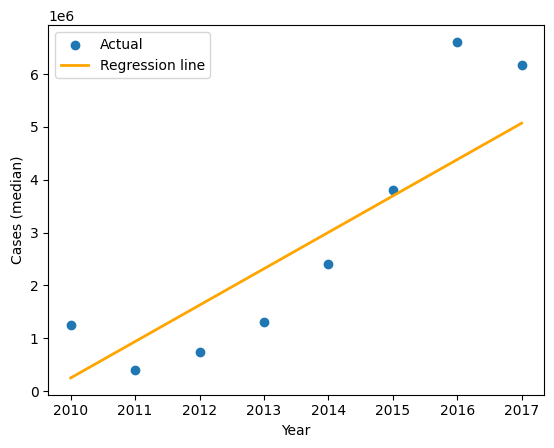

In [27]:
# Generated a sequence of Year values
years = np.linspace(rwanda['Year'].min(), rwanda['Year'].max(), 100)
deaths_mean = rwanda['No. of deaths_median'].mean()
X_line = np.column_stack([years, np.full_like(years, deaths_mean)])
X_line_scaled = scaler.transform(X_line)

preds = model.predict(X_line_scaled)

plt.scatter(rwanda['Year'], rwanda['No. of cases_median'], label='Actual')
plt.plot(years, preds, color='orange', linewidth=2, label='Regression line')
plt.xlabel('Year'); plt.ylabel('Cases (median)')
plt.legend(); plt.show()

In [29]:
dt = DecisionTreeRegressor(random_state=0).fit(X_train_s, y_train)
rf = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train_s, y_train)

models = {
    'LinearReg':    model,
    'DecisionTree': dt,
    'RandomForest': rf
}

for name, m in models.items():
    preds = m.predict(X_test_s)
    mse   = mean_squared_error(y_test, preds)
    print(f"{name} Test MSE: {mse:.2f}")

LinearReg Test MSE: 1623507590202.59
DecisionTree Test MSE: 155375500902.50
RandomForest Test MSE: 2796515440407.96


In [30]:
# Suppose RF was best:
best = rf
joblib.dump(best,   'best_model.pkl')
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [32]:
scaler = joblib.load('scaler.pkl')
model  = joblib.load('best_model.pkl')

def predict_cases(year:int, deaths_median:int) -> float:
    X = np.array([[year, deaths_median]])
    Xs = scaler.transform(X)
    return float(model.predict(Xs)[0])
